# Style Transfer

In this notebook, we will go through basics of neural style transfer. 

Here we will use [PyTorch](https://pytorch.org/tutorials/  "PyTorch Tutorial").


Everything is explained in-detail in [blog post](https://dudeperf3ct.github.io/style/transfer/2018/12/23/Magic-of-Style-Transfer/). This is notebook which replicates the result of blog and runs in colab. Enjoy!


#### Run in Colab

You can run this notebook in google colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dudeperf3ct/DL_notebooks/blob/master/Style%20Transfer/style_transfer_pytorch.ipynb)

In [0]:
!pip install --upgrade torch torchvision 

In [0]:
#uncomment this to upload kaggle.json

from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

In [0]:
#uncomment this to upload kaggle.json

from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

In [24]:
import imageio
from PIL import Image
import torch
from torchvision import transforms, models
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print ('Training on...', device)

Training on... cuda


In [0]:
input_image = 'cat.jpg'
style_input_image = 'picasso.jpg'

In [123]:
model = models.vgg16(pretrained=True).features

for param in model.parameters():
    param.requires_grad_(False)
    
model.to(device)

model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

In [0]:
width, height = Image.open(input_image).size      #input image dimension
img_nrows = 400
img_ncols = int(width * img_nrows / height)       #output image dimension

size = (img_nrows, img_ncols)

def preprocess_image(image_path):
    
    image = Image.open(image_path)
  
    tfms = transforms.Compose([transforms.Resize(size),
                              transforms.ToTensor(),
                              transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
  
    img = tfms(image).unsqueeze(0)
    return img
    
def deprocess_tensor(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image
  

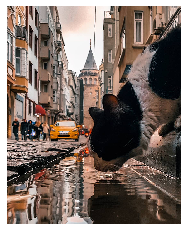

In [125]:
# content image
content = imageio.imread(input_image)
plt.xticks([])
plt.yticks([])
plt.grid(visible=False)
imshow(content)

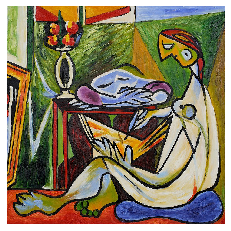

In [126]:
# style image
style = imageio.imread(style_input_image)
plt.xticks([])
plt.yticks([])
plt.grid(visible=False)
plt.grid(visible=False)
imshow(style)

## Gatys et al 

Paper: [Link](https://arxiv.org/pdf/1508.06576.pdf)

Code Adapted from: [Here](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/style-transfer/Style_Transfer_Solution.ipynb)

In [0]:
content_image = preprocess_image(input_image).to(device)
style_image = preprocess_image(style_input_image).to(device)
generated_image = content_image.clone().requires_grad_(True).to(device)

assert (content_image.shape == style_image.shape == generated_image.shape)

In [128]:
for name, layer in model._modules.items():
  print (name, layer)

0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 ReLU(inplace)
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 ReLU(inplace)
4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 ReLU(inplace)
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 ReLU(inplace)
9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 ReLU(inplace)
12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 ReLU(inplace)
14 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 ReLU(inplace)
16 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
17 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
18 ReLU(inplace)
19 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
20 ReLU

In [0]:
content_layers = {'21': 'conv4_2'}
style_layers = {'0' : 'conv1_1', 
                '5' : 'conv2_1', 
                '10' : 'conv3_1', 
                '19' : 'conv4_1', 
                '24' : 'conv5_1'}
target_layers = content_layers
target_layers.update(style_layers)

In [0]:
def get_features(layer_dict, x):

    features = {}
    
    for name, layer in model._modules.items():
      x = layer(x)
      if name in layer_dict:
        features[layer_dict[name]] = x

    return features

In [131]:
content_features = get_features(content_layers, content_image)
style_features = get_features(style_layers, style_image)
len(content_features), len(style_features)

(6, 5)

In [0]:
def gram_matrix(tensor):
    
    _, d, h, w = tensor.size()
    
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    
    return gram
  
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [133]:
# for displaying the target image, intermittently
show_every = 200
content_weight = 1
style_weight = 1e5
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

# iteration hyperparameters
optimizer = optim.Adam([generated_image], lr=0.003)
iterations = 2000  # decide how many iterations to update your image (5000)

for i in range(iterations):
    
    # target features from generated image
    target_features = get_features(target_layers, generated_image)
    
    # content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # style loss
    style_loss = 0
   
    for layer in style_weights:

        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        
        style_gram = style_grams[layer]

        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        
        style_loss += layer_style_loss / (d * h * w)
        
    # total loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update generated image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  i % show_every == 0:
        print('Iteration:', i, 'Total loss: ', total_loss.item())


Iteration: 0 Total loss:  29731900.0
Iteration: 200 Total loss:  2773380.75
Iteration: 400 Total loss:  1493747.625
Iteration: 600 Total loss:  953629.875
Iteration: 800 Total loss:  650908.125
Iteration: 1000 Total loss:  470760.84375
Iteration: 1200 Total loss:  358807.3125
Iteration: 1400 Total loss:  284510.34375
Iteration: 1600 Total loss:  232766.9375
Iteration: 1800 Total loss:  195073.859375


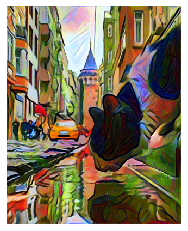

In [134]:
img = deprocess_tensor(generated_image)
plt.xticks([])
plt.yticks([])
plt.grid(visible=False)
imshow(img)

## Johnson et al

Paper: [Link](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf)

Code and pretrained models  from: [Here](https://github.com/pytorch/examples/tree/master/fast_neural_style)

In [0]:
# # # Load the Drive helper and mount
# from google.colab import drive

# # # This will prompt for authorization.
# drive.mount('/content/drive')

In [0]:
# # After executing the cell above, Drive
# # files will be present in \"/content/drive/My Drive

# !ls "/content/drive/My Drive/Colab Notebooks/"

In [0]:
# !cp -r "/content/drive/My Drive/Colab Notebooks/pytorch_saved_models" "pytorch_models/"

In [0]:
!wget 'cs231n.stanford.edu/coco-animals.zip'
!unzip 'coco-animals.zip'
!rm 'coco-animals.zip'

In [13]:
import os, random, re

path = 'coco-animals/val'
random_dir = random.choice(os.listdir(path))
random_image = random.choice(os.listdir(os.path.join(path, random_dir)))
image_path = os.path.join(os.path.join(path, random_dir), random_image)
print (random_image, image_path)

COCO_val2014_000000161557.jpg coco-animals/val/dog/COCO_val2014_000000161557.jpg


In [14]:
# style pretrained pytorch models
print (os.listdir('pytorch_models/'))
random_style = random.choice(os.listdir('pytorch_models/'))

style_model_path = os.path.join('pytorch_models/', random_style)
print (random_style)

['rain_princess.pth', 'mosaic.pth', 'udnie.pth', 'candy.pth']
rain_princess.pth


In [0]:
class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        # Initial convolution layers
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2 = torch.nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3 = torch.nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = torch.nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = torch.nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ConvLayer(32, 3, kernel_size=9, stride=1)
        # Non-linearities
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y


class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class ResidualBlock(torch.nn.Module):
    """ResidualBlock
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    """

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out


class UpsampleConvLayer(torch.nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

In [0]:
def load_image(filename, size=None, scale=None):
    img = Image.open(filename)
    if size is not None:
        img = img.resize((size, size), Image.ANTIALIAS)
    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
    return img
  
def deprocess_image(data):
    img = data.clone().clamp(0, 255).detach().numpy()
    img = img.transpose(1, 2, 0).astype("uint8")
    img = Image.fromarray(img)
    return img

In [0]:
content_image = load_image(image_path)

content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))])

content_image = content_transform(content_image)
content_image = content_image.unsqueeze(0).to(device)

In [0]:
style_model = TransformerNet()
state_dict = torch.load(style_model_path)

for k in list(state_dict.keys()):
    if re.search(r'in\d+\.running_(mean|var)$', k):
      del state_dict[k]
      
style_model.load_state_dict(state_dict)
style_model.to(device)

In [0]:
output = style_model(content_image).cpu()

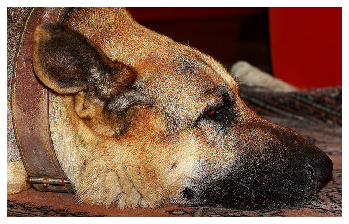

In [20]:
plt.xticks([])
plt.yticks([])
plt.grid(visible=False)
imshow(Image.open(image_path))

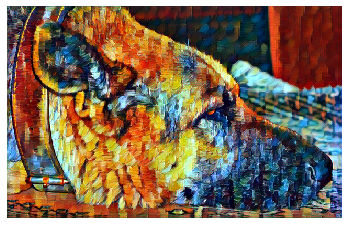

In [21]:
img = deprocess_image(output[0])
plt.xticks([])
plt.yticks([])
plt.grid(visible=False)
imshow(img)